# **CSE343: *Machine Learning Assignment-1***

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

## **Section B (Scratch Implementation)**

In [2]:
from utils import split_dataset, standardize, LogisticRegression

### **Utility Functions**

In [3]:
def plot(model: LogisticRegression, show: bool|None = True, save: bool|None = False) -> None:
    """
    plot the training/validation loss and training/validation accuracy per iteration
    """

    fig, ax = plt.subplots(1, 2, figsize=(13, 3.5))
    fig.suptitle(model)

    plt.subplot(1, 2, 1)
    plt.plot(model.train_loss, label="Training")
    plt.plot(model.valid_loss, label="Validation")

    plt.subplot(1, 2, 2)
    plt.plot(model.train_accuracy, label="Training")
    plt.plot(model.valid_accuracy, label="Validation")
    plt.axhline(model.accuracy(x_test, y_test), color="red", linestyle="--", label="Final Test Accuracy")

    for i, curve in enumerate(["Loss", "Accuracy"], start=1):
        plt.subplot(1, 2, i)
        plt.xlabel("# of Iterations")
        plt.ylabel(curve)
        plt.title(f"Training vs Validation {curve} Curve")
        plt.legend()

    if save: plt.savefig(f"Assets/{model}.png")
    if show: plt.show()

### **Dataset Loading, Pre-Processing, and Splitting**

Since we intend to use the Logistic Regression classifier, it is ideal to standardize the data to avoid different scales on different features, and give them equal importance instead. It also helps the gradient descent converge faster by avoiding too large or too small steps. The equation for standardization is given below

$$X^{*} = \frac{X - \mu_{X}}{\sigma_{X}}$$

where $X$ is the feature matrix, $\mu_{X}$ is the mean of $X$, and $\sigma_{X}$ is the standard deviation of $X$.

We then split the dataset into $70 \%$ training, $20 \%$ testing, and $10 \%$ validation data. 

In [9]:
df = pd.read_csv(r"Datasets/health care diabetes.csv")
y = df["Outcome"].values
x = standardize(df.drop("Outcome", axis=1).values)
(x_train, y_train), (x_test, y_test), (x_valid, y_valid) = split_dataset(x, y, [0.7, 0.2, 0.1])

### **Training the Model**

We train a Logistic Regression model on the training data and get a rough idea of its performance using the validation set. The model is trained by implementing stochastic gradient descent on the model weights $\theta$. 

We make use of Cross-Entropy Loss (also called Log-Loss). It is defined as follows

$$\begin{align*}
    J(\theta) &= -\frac{1}{N} \sum_{i=1}^{N} \left[ y_{i} \log{(h_{\theta}(x_{i}))} + (1 - y_{i}) \log{(1 - h_{\theta}(x_{i}))} \right] \\
    h_{\theta}(x_{i}) &= \frac{1}{1 + e^{-\theta^{T}x_{i}}}
\end{align*}$$

In [10]:
model = LogisticRegression(alpha=0.005, epochs=70)
model.fit(x_train, y_train, x_valid, y_valid)
model.train(verbose=True)

print("Testing Accuracy:", model.accuracy(x_test, y_test))

Testing Accuracy: 0.7532467532467533


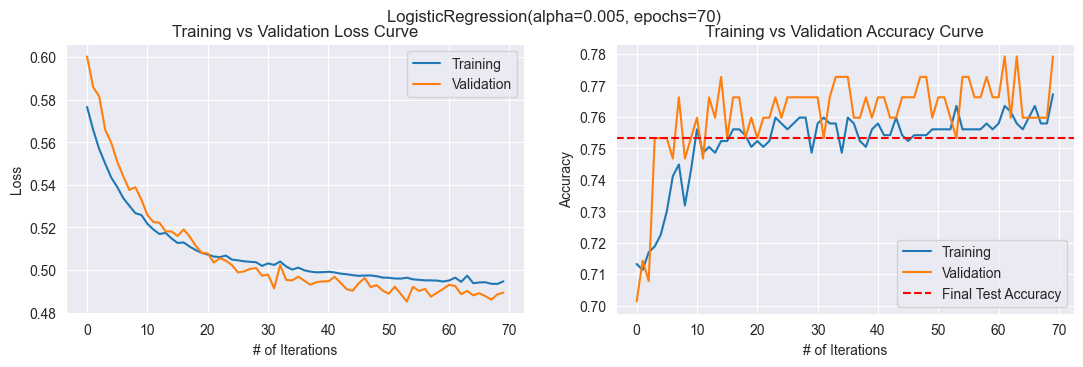

In [11]:
plot(model, show=True)

### **Observations**

On average, the model perfoms well on both the training and testing data. With sufficient number of epochs, the model converges fairly quickly. The model also performs well on the validation data, which is a good indicator that the model is not overfitting.

### **Testing Different Model Parameters**

We test the model with different values of the learning rate $\alpha$. A total of four models, with $\alpha = 1.0$, $0.1$, $0.01$, and $0.001$ are trained and their performance is analysed. The results are shown below.

In [19]:
models = [
    LogisticRegression(alpha=alpha, epochs=epochs) 
    for alpha, epochs in [[1, 125], [0.1, 125], [0.01, 125], [0.001, 125]]
]

accuracy = np.zeros((len(models), 3))
for i, model in enumerate(models):
    model.fit(x_train, y_train, x_valid, y_valid)
    model.train(verbose=False)
    accuracy[i, 0] = model.accuracy(x_train, y_train)
    accuracy[i, 1] = model.accuracy(x_valid, y_valid)
    accuracy[i, 2] = model.accuracy(x_test, y_test)

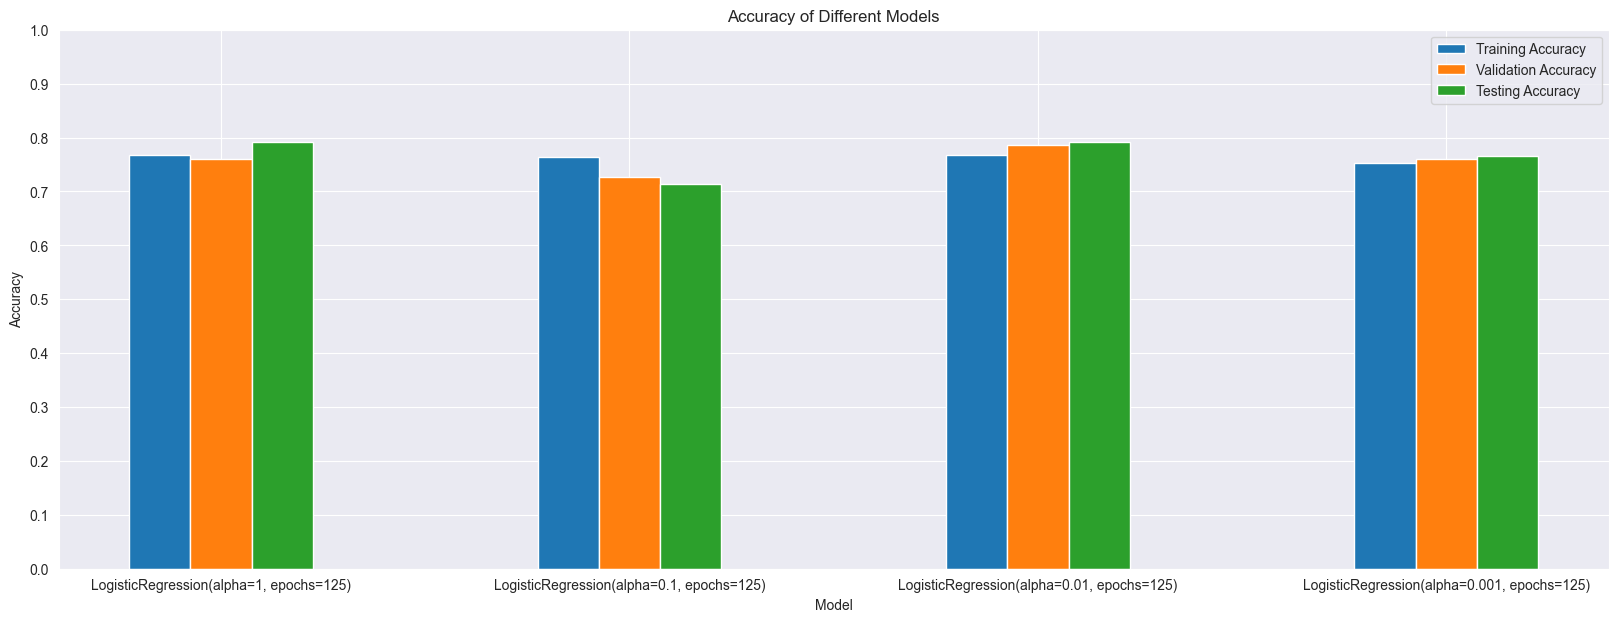

In [20]:
width = 0.15
plt.figure(figsize=(20, 7))

plt.bar(np.arange(4) - width, accuracy[:, 0], width, label="Training Accuracy")
plt.bar(np.arange(4), accuracy[:, 1], width, label="Validation Accuracy")
plt.bar(np.arange(4) + width, accuracy[:, 2], width, label="Testing Accuracy")

plt.xticks(np.arange(4), models)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)

plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of Different Models")

plt.legend()
plt.show()

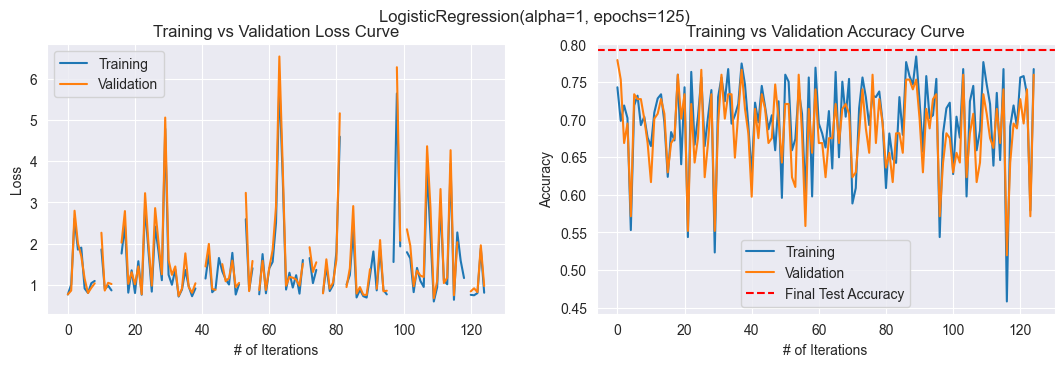

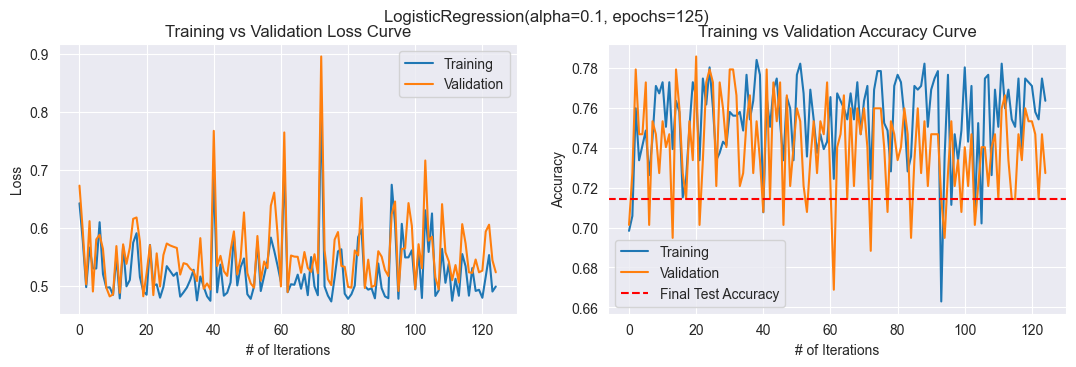

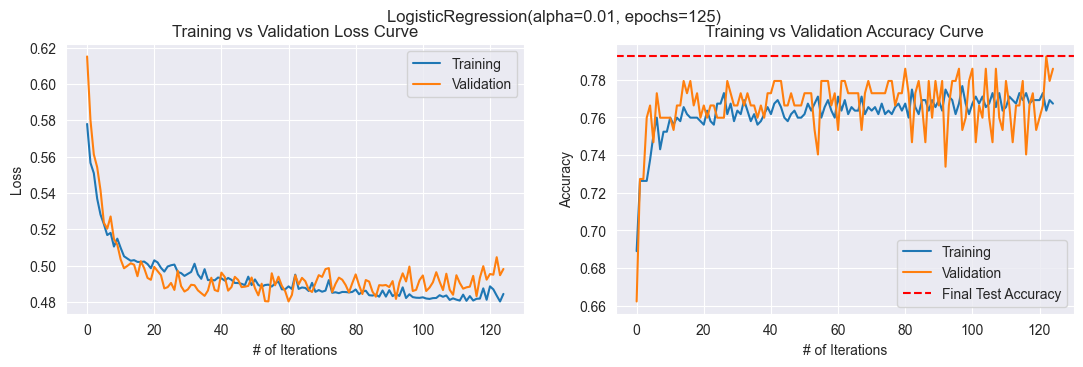

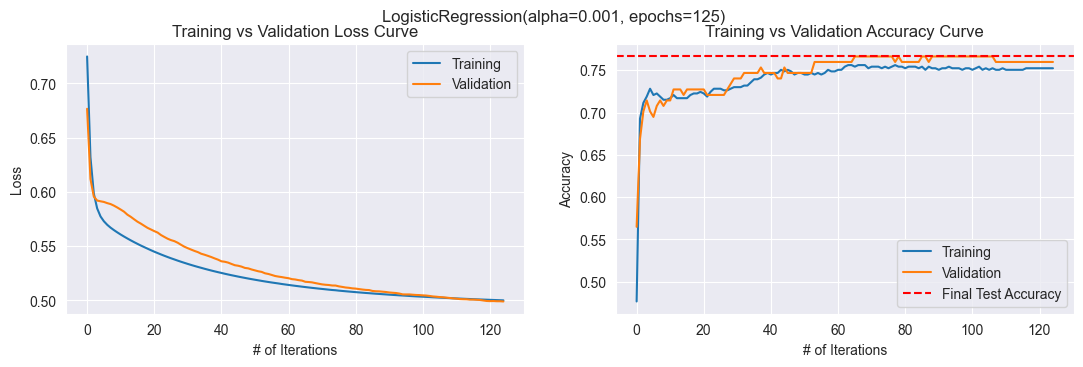

In [21]:
for model in models:
    plot(model, show=True)

### **Observations**

The model with $\alpha = 1.0$ and $\alpha = 0.1$ perform the worst. The loss and accuracy differ wildly per iteration, suggesting that the learning rate is too high. 

The model with $\alpha = 0.01$ performs the best. The loss and accuracy are fairly stable per iteration, and the model converges quickly. $\alpha = 0.001$ is also a good choice, although the model takes a little longer to converge.

### **Confusion Matrices and Error Analysis of the Models**

For the above four models, with different learning rates and number of iterations, we generate the Confusion Matrix for each model for the test data. We also calculate the Accuracy, Precision, Recall, and F1-Score for each model. The confusion matrix is structured as follows

| | Actual Positive | Actual Negative |
|:---:|:---:|:---:|
| **Predicted Positive** | True Positive $(TP)$ | False Positive $(FP)$ |
| **Predicted Negative** | False Negative $(FN)$ | True Negative $(TN)$ |

We also investigate the following confusion metrics of the models

$$\begin{align*}
    \text{Accuracy} &= \frac{TP + TN}{TP + TN + FP + FN} \\
    \text{Precision} &= \frac{TP}{TP + FP} \\
    \text{Recall} &= \frac{TP}{TP + FN} \\
    \text{F1-Score} &= \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
\end{align*}$$

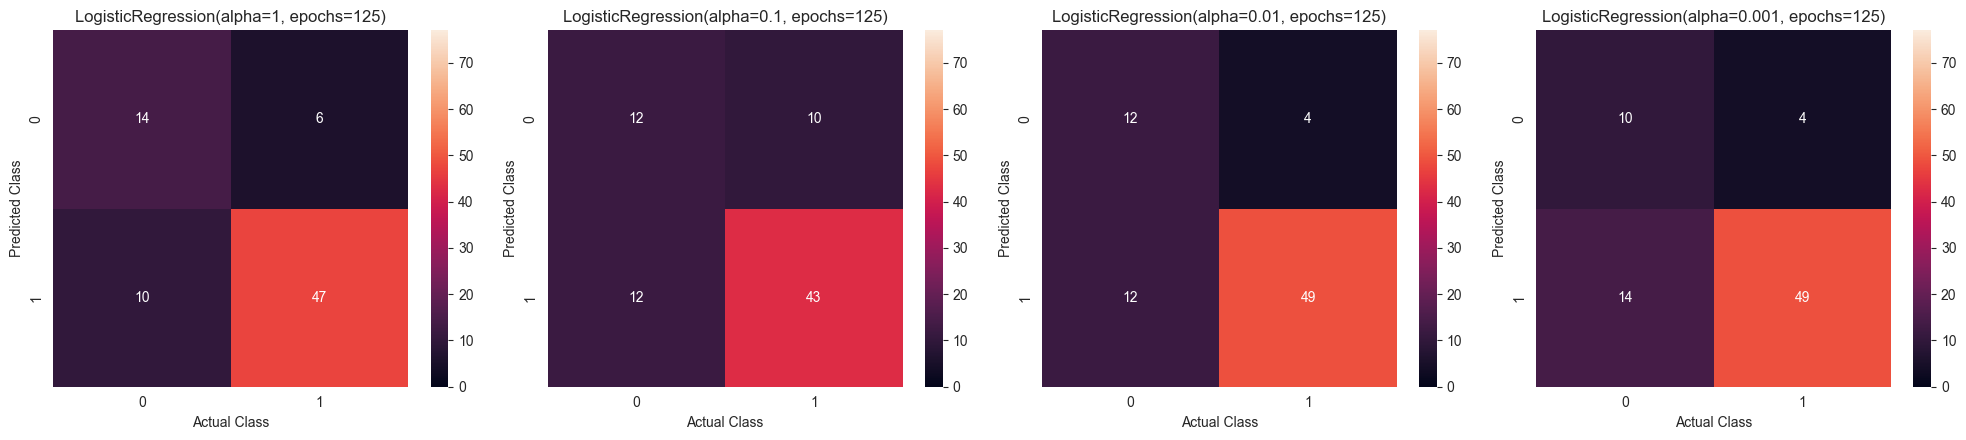

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4.5))

for i, model in enumerate(models, start=1):
    plt.subplot(1, 4, i)
    plt.title(model)
    sns.heatmap(model.confusion_matrix(x_test, y_test), vmin=0, vmax=x_test.shape[0], annot=True, fmt="d")
    plt.xlabel("Actual Class")
    plt.ylabel("Predicted Class")

plt.tight_layout()
plt.show()

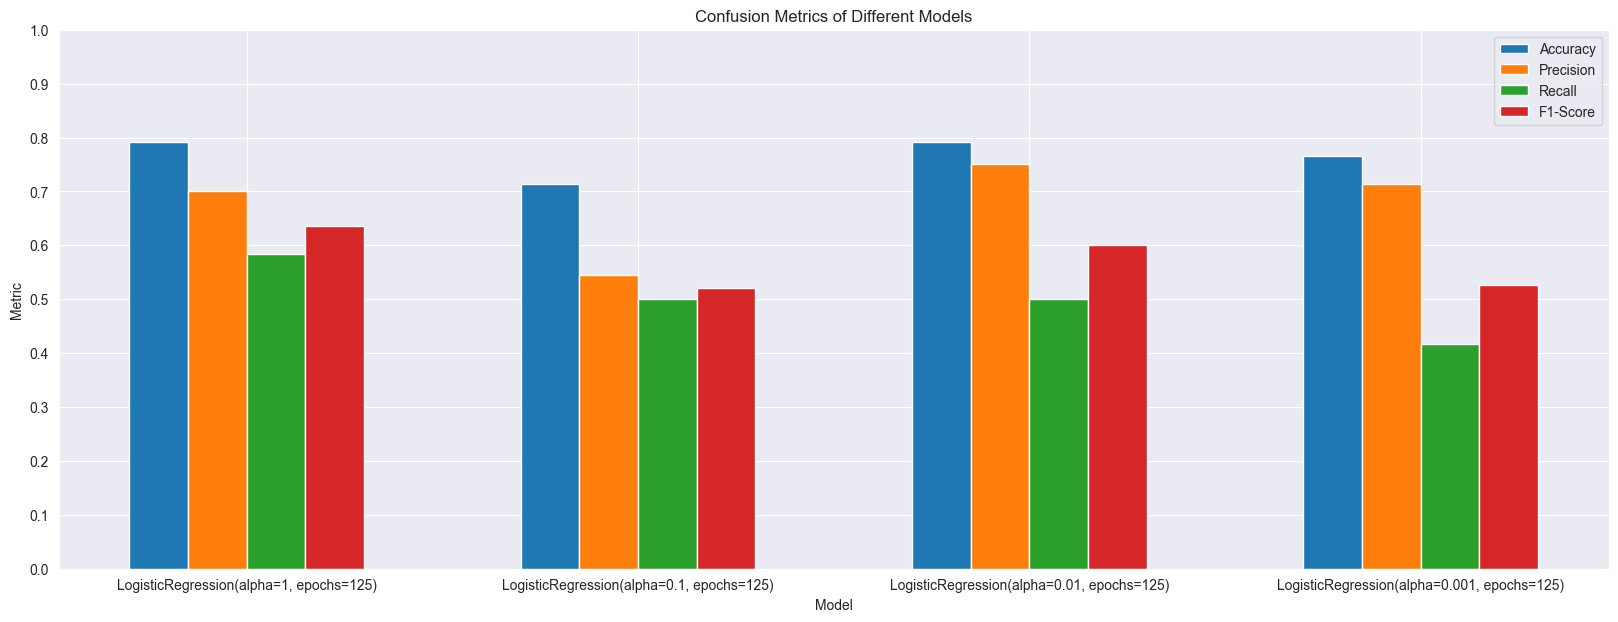

In [23]:
width = 0.15
plt.figure(figsize=(20, 7))

metrics = np.zeros((len(models), 4))
for i, model in enumerate(models):
    metrics[i] = model.confusion_metrics(x_test, y_test)

plt.bar(np.arange(4) - 1.5*width, metrics[:, 0], width, label="Accuracy")
plt.bar(np.arange(4) - 0.5*width, metrics[:, 1], width, label="Precision")
plt.bar(np.arange(4) + 0.5*width, metrics[:, 2], width, label="Recall")
plt.bar(np.arange(4) + 1.5*width, metrics[:, 3], width, label="F1-Score")

plt.xticks(np.arange(4), models)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)

plt.xlabel("Model")
plt.ylabel("Metric")
plt.title("Confusion Metrics of Different Models")

plt.legend()
plt.show()

### **Regularization in Loss Function**

We now add a regularization term to the loss function to avoid overfitting to the training data. We try two different regularization terms, namely $L_{1}$ (Lasso) and $L_{2}$ (Ridge) regularization. The regularization terms are given as follows, along with the modified loss function

$$\begin{align*}
    L_{1} &= \lambda \sum_{j=1}^{d} |\theta_{j}| \\
    L_{2} &= \lambda \sum_{j=1}^{d} \theta_{j}^{2} \\
    J_{L_{k}}(\theta) &= J(\theta) + L_{k}
\end{align*}$$

The above regularization terms are added to the loss function, and the model is trained again. The regularized loss function is minimized. We try to find a good value for $\lambda$, the regularization parameter by trying out different values.

In [24]:
models = [
    LogisticRegression(alpha=0.001, epochs=80, regularization=regularization, lamda=lamda)
    for regularization, lamda in [(None, 0.0), ("L1", 1e-3), ("L2", 1e-5)]
]

for i, model in enumerate(models):
    model.fit(x_train, y_train, x_valid, y_valid)
    model.train(verbose=False)

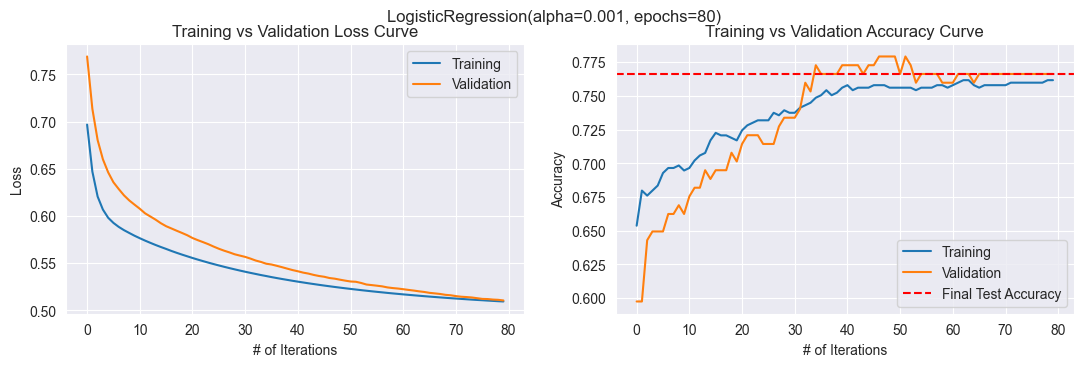

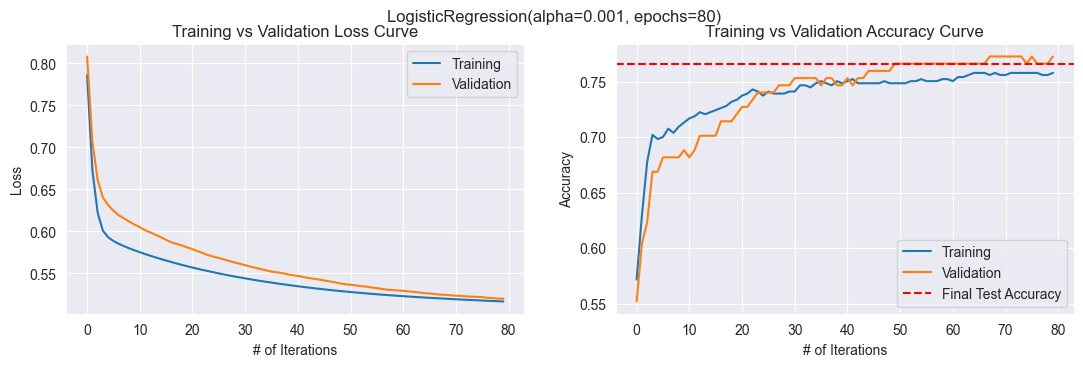

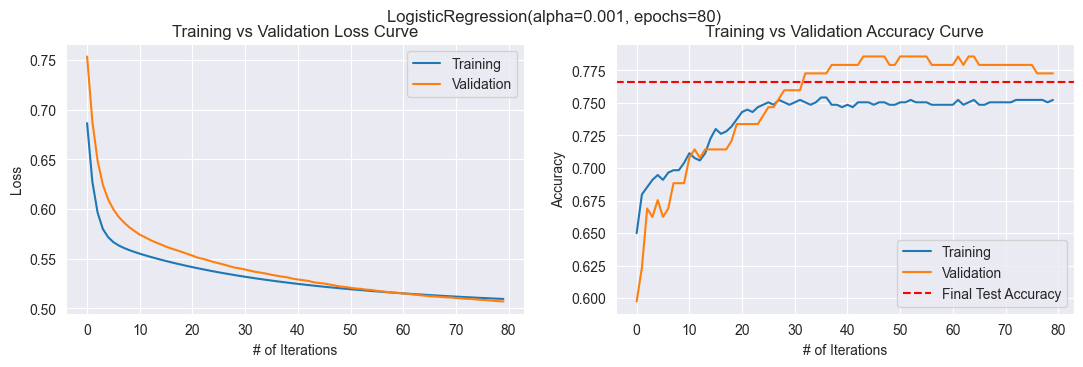

In [25]:
for model in models:
    plot(model, show=True)

### **Observations**

The addition of regularization makes the model perform more consistently. The loss and accuracy are more stable per iteration, and the model converges faster. 

For $L_{1}$ regularization, a value of $\lambda \in [10^{-3}, 10^{-4}]$ works well. For $L_{2}$ regularization, a value of $\lambda \in [10^{-3}, 10^{-5}]$ works well.

### **Using a different logisitic function**

Next, we change the logistic function being used by the Logistic Regressor. Instead of the sigmoid function, we use $\tanh{x}$ function, the hyperbolic tangent. It is a valid logistic function, because

$$\begin{align*}
    \tanh{(x)} &= \frac{\sinh{(x)}}{\cosh{(x)}} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} \\
    &= \frac{1 - e^{-2x}}{1 + e^{-2x}} = \frac{2}{1 + e^{-2x}} - \frac{1 + e^{-2x}}{1 + e^{-2x}} \\
    &= \frac{2}{1 + e^{-2x}} - 1
\end{align*}$$

This returns a value in the range $[-1, 1]$, so we scale it to the range $[0, 1]$ by adding $1$ and dividing by $2$. The new logistic function is given as follows

$$h_{\theta}(x) = \frac{1}{2} \cdot (1 + \tanh{(\theta^{T}x)})$$

We can still use the Cross-Entropy Loss function to calculate loss and perform gradient descent. The gradient is also modified according to the new logistic function.

In [26]:
(x_train, y_train), (x_test, y_test), (x_valid, y_valid) = split_dataset(x, y, [0.7, 0.2, 0.1])
model = LogisticRegression(alpha=0.005, epochs=75, logistic="tanh")
model.fit(x_train, y_train, x_valid, y_valid)
model.train(verbose=True)

print("Testing Accuracy:", model.accuracy(x_test, y_test))

Testing Accuracy: 0.7402597402597403


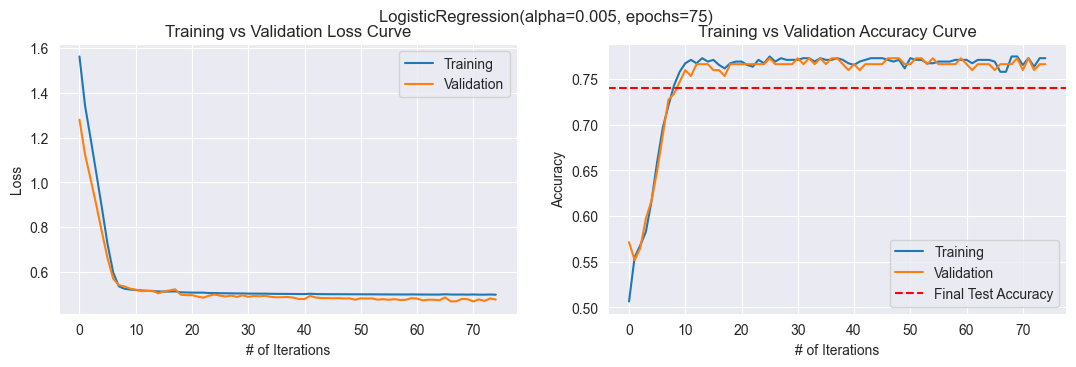

In [27]:
plot(model, show=True)

**Observations**

The model using $\tanh{x}$ as the logistic function performs steeply better than the model using the sigmoid function. The loss decreases and the accuracy inceases on both the training and testing data very quickly. This is an indicator that the model is converging faster.

### **Using Batch Gradient Descent**

Instead of using fixed Stochastic Gradient Descent, we use Mini-Batch Gradient Descent to train the next model. We try multiple batch sizes and analyze the plots. The results are shown below.

In [33]:
model = LogisticRegression(alpha=0.001, epochs=120, batch_size=275)
model.fit(x_train, y_train, x_valid, y_valid)
model.train(verbose=True)

print("Testing Accuracy:", model.accuracy(x_test, y_test))

Testing Accuracy: 0.7142857142857143


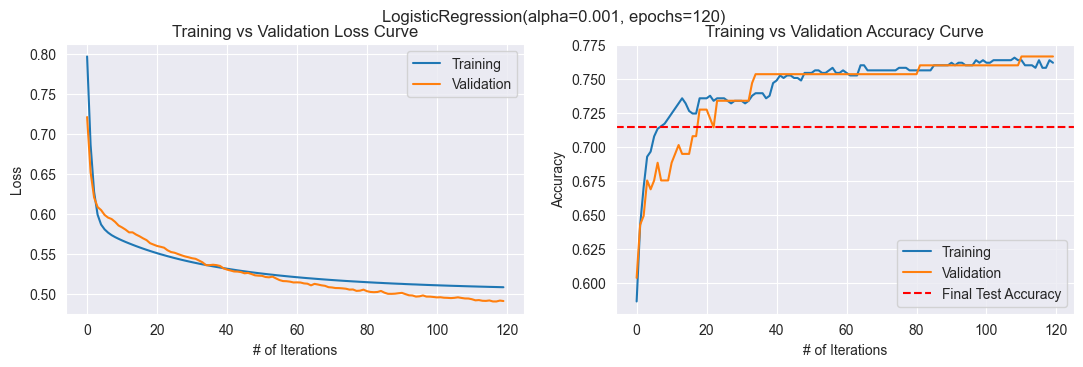

In [34]:
plot(model, show=True)

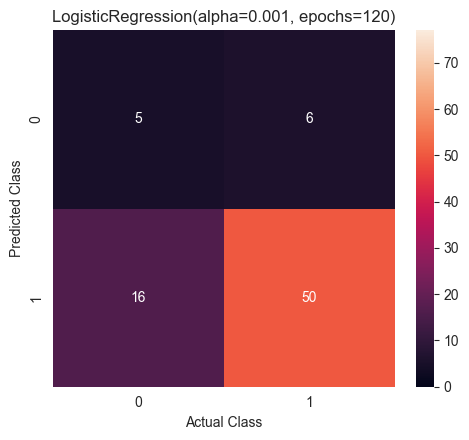

In [35]:
plt.figure(figsize=(5, 4.5))
plt.title(model)
sns.heatmap(model.confusion_matrix(x_test, y_test), vmin=0, vmax=x_test.shape[0], annot=True, fmt="d")
plt.xlabel("Actual Class")
plt.ylabel("Predicted Class")
plt.tight_layout()
plt.show()

In [36]:
accuracy, precision, recall, f1_score = model.confusion_metrics(x_test, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)

Accuracy: 0.7142857142857143
Precision: 0.45454545454545453
Recall: 0.23809523809523808
F1-Score: 0.31249999999999994


### **Observations**

The Mini-Batch Gradient Descent variant of the model performs better than the Stochastic Gradient Descent variant. This is because in each epoch, the model gets exposed to more data. This makes the model converge faster.

Another observation is that as the batch size increases, the average performance of the model increases and then stabilizes.

## **Section C (Algorithm Implementation using Packages)**

In [37]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_error as MAE

### **Utility Functions**

In [38]:
def evaluate_model(model: LinearRegression, x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray) -> tuple[tuple[float]]:
    """
    evaluate the model on the training and testing data.
    """

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    mse_train, mse_test = MSE(y_train, y_train_pred), MSE(y_test, y_test_pred)
    rmse_train, rmse_test = np.sqrt(mse_train), np.sqrt(mse_test)
    r2_train, r2_test = r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

    m, n = x_train.shape
    adj_r2_train = 1 - (1 - r2_train) * (m - 1) / (m - n - 1)
    m, n = x_test.shape
    adj_r2_test = 1 - (1 - r2_test) * (m - 1) / (m - n - 1)

    mae_train, mae_test = MAE(y_train, y_train_pred), MAE(y_test, y_test_pred)

    return (mse_train, rmse_train, r2_train, adj_r2_train, mae_train), (mse_test, rmse_test, r2_test, adj_r2_test, mae_test)

### **Dataset Loading and Data Analysis**

We load the huge dataset and perform basic analysis on it. Some box plots, pair plots, pie charts, etc. are generated to get an idea about the dataset.

In [39]:
df = pd.read_csv("Datasets/CO2 Emissions.csv")
df.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


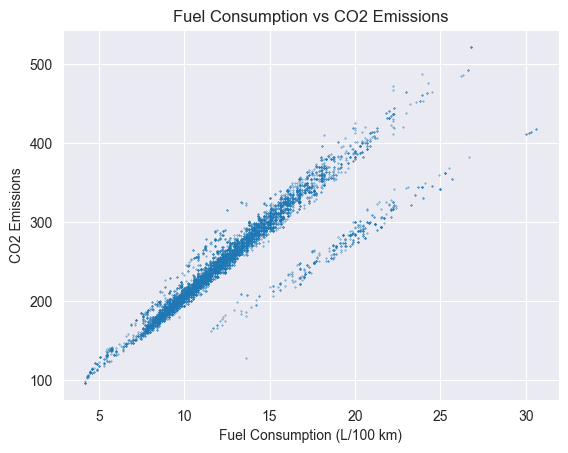

In [40]:
plt.scatter(df["Fuel Consumption City (L/100 km)"], df["CO2 Emissions(g/km)"], s=0.1)
plt.xlabel("Fuel Consumption (L/100 km)")
plt.ylabel("CO2 Emissions")
plt.title("Fuel Consumption vs CO2 Emissions")
plt.show()

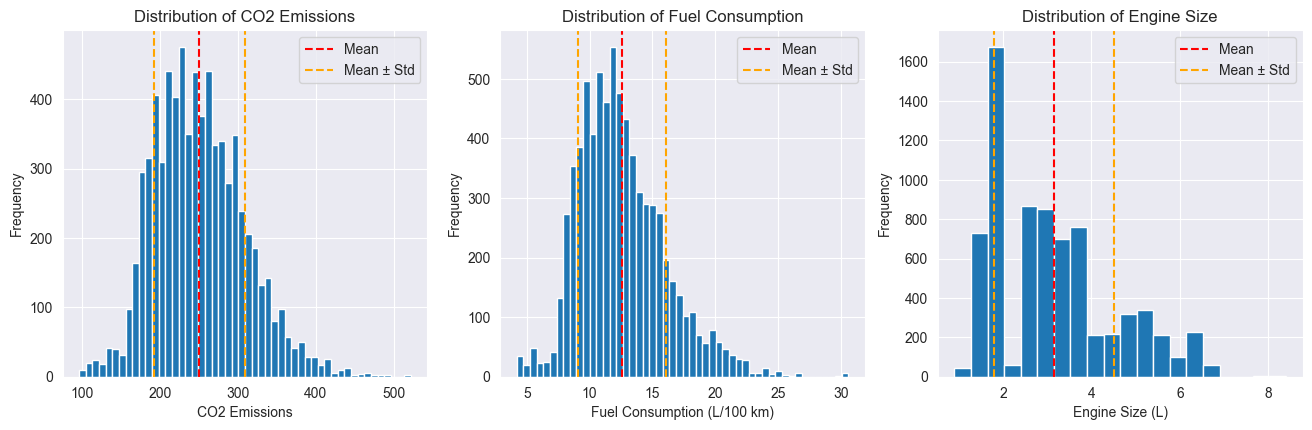

In [41]:
plt.subplots(1, 3, figsize=(16, 4.5))

plt.subplot(1, 3, 1)
mean = np.mean(df["CO2 Emissions(g/km)"])
std = np.std(df["CO2 Emissions(g/km)"])
plt.hist(df["CO2 Emissions(g/km)"], bins=50)
plt.axvline(mean, color="red", linestyle="--", label="Mean")
plt.axvline(mean+std, color="orange", linestyle="--", label="Mean ± Std")
plt.axvline(mean-std, color="orange", linestyle="--")
plt.xlabel("CO2 Emissions")
plt.ylabel("Frequency")
plt.title("Distribution of CO2 Emissions")
plt.legend()

plt.subplot(1, 3, 2)
mean = np.mean(df["Fuel Consumption City (L/100 km)"])
std = np.std(df["Fuel Consumption City (L/100 km)"])
plt.hist(df["Fuel Consumption City (L/100 km)"], bins=50)
plt.axvline(mean, color="red", linestyle="--", label="Mean")
plt.axvline(mean+std, color="orange", linestyle="--", label="Mean ± Std")
plt.axvline(mean-std, color="orange", linestyle="--")
plt.xlabel("Fuel Consumption (L/100 km)")
plt.ylabel("Frequency")
plt.title("Distribution of Fuel Consumption")
plt.legend()

plt.subplot(1, 3, 3)
mean = np.mean(df["Engine Size(L)"])
std = np.std(df["Engine Size(L)"])
plt.hist(df["Engine Size(L)"], bins=20)
plt.axvline(mean, color="red", linestyle="--", label="Mean")
plt.axvline(mean+std, color="orange", linestyle="--", label="Mean ± Std")
plt.axvline(mean-std, color="orange", linestyle="--")
plt.xlabel("Engine Size (L)")
plt.ylabel("Frequency")
plt.title("Distribution of Engine Size")
plt.legend()

plt.show()

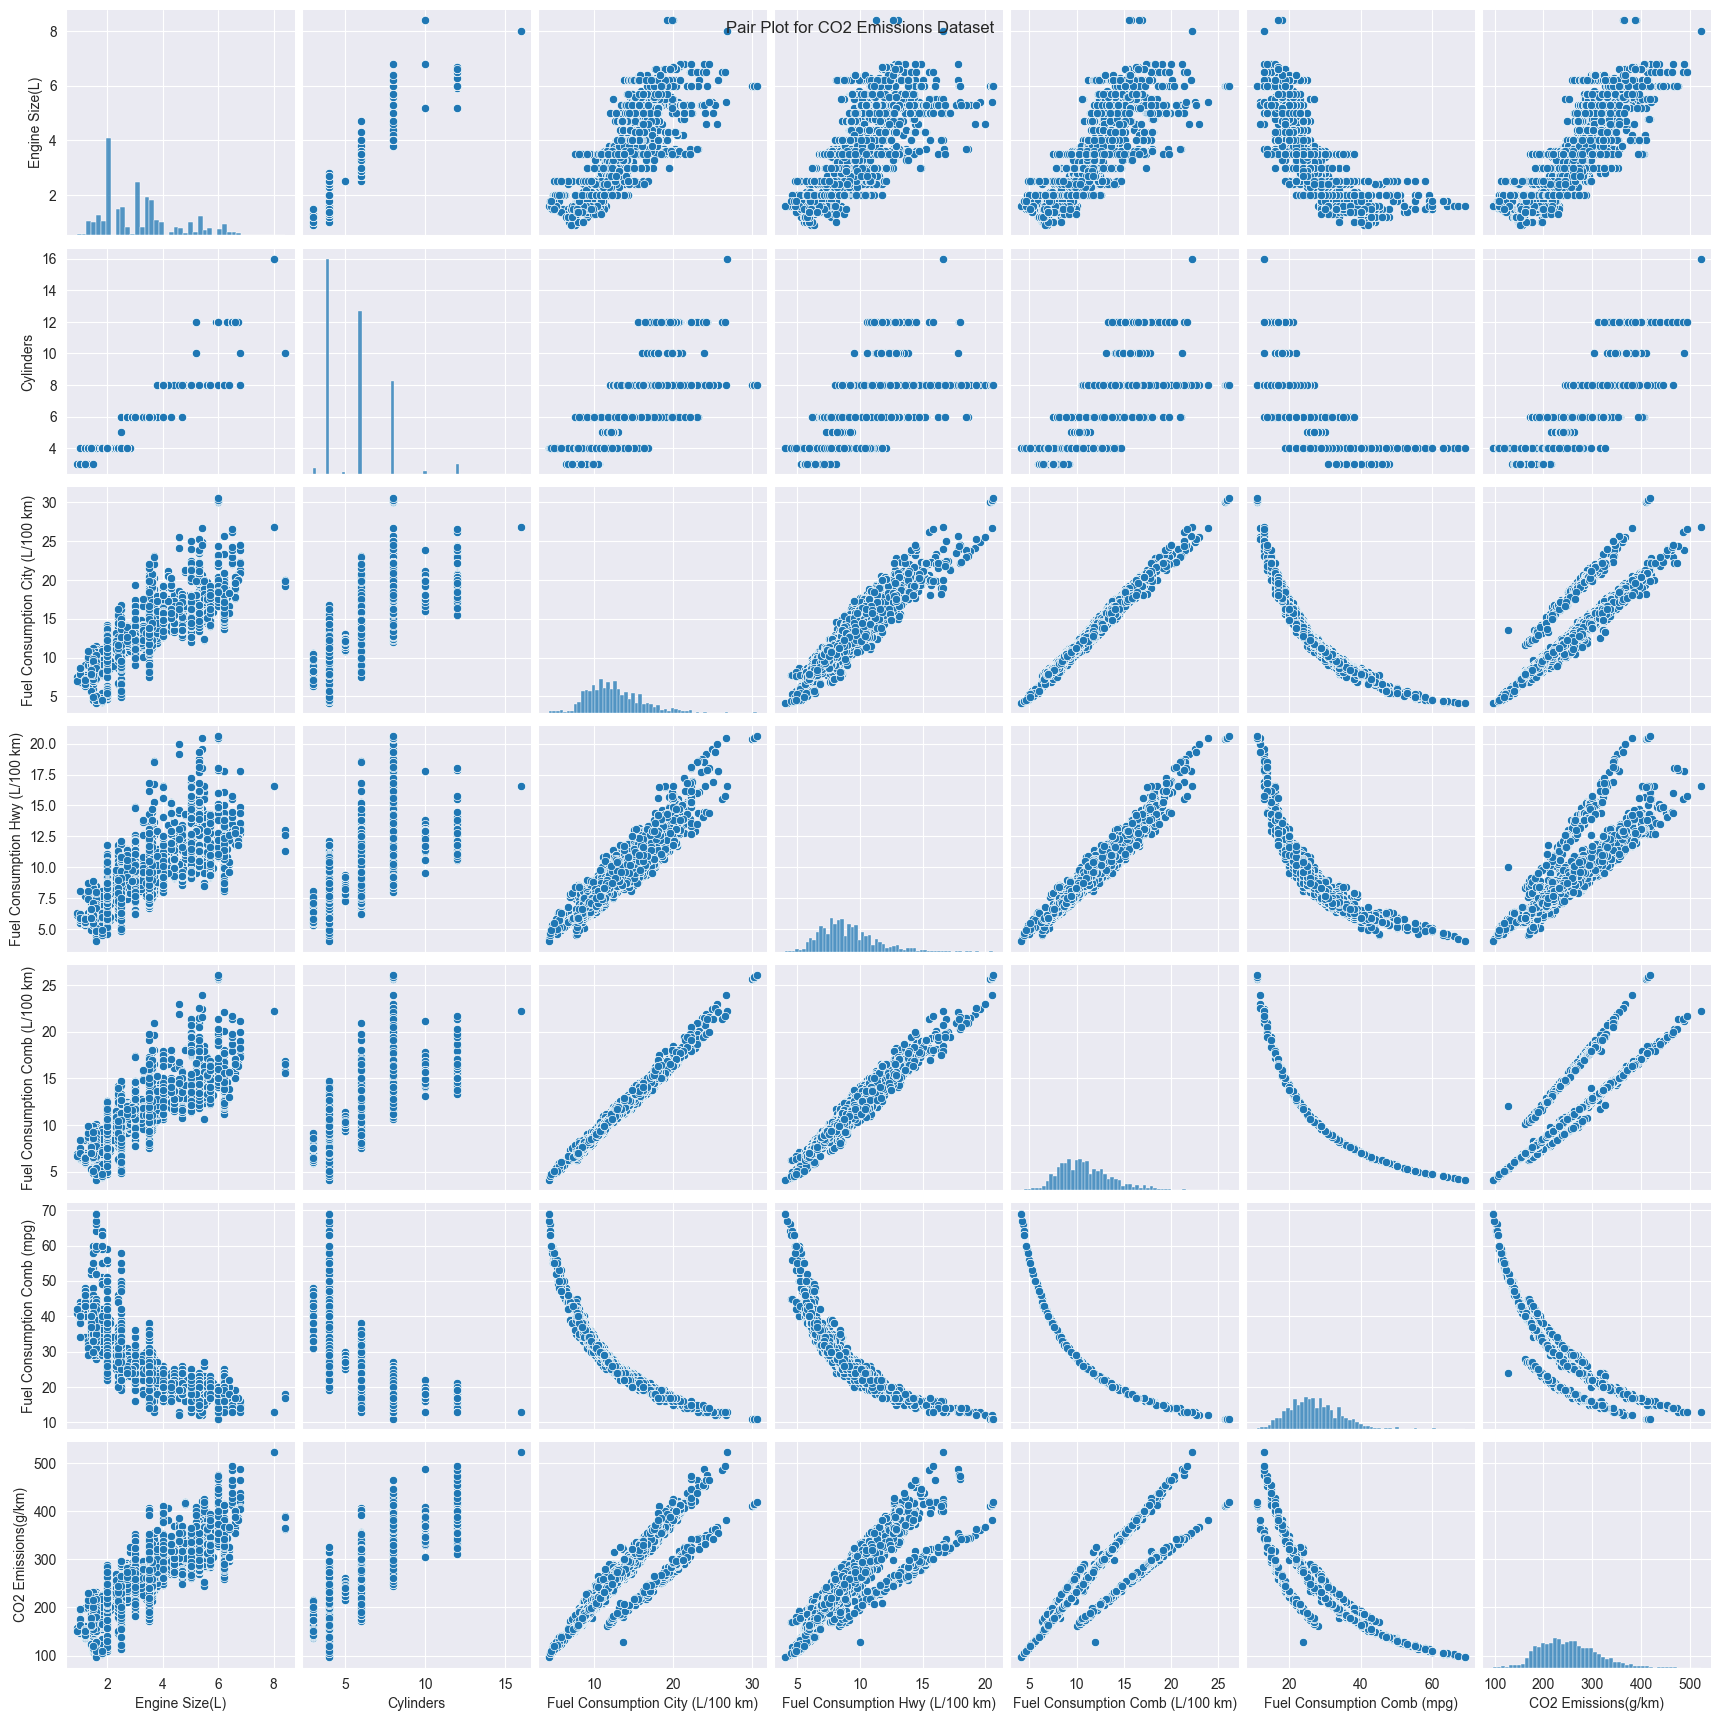

In [42]:
sns.pairplot(df)
plt.suptitle("Pair Plot for CO2 Emissions Dataset")
plt.show()

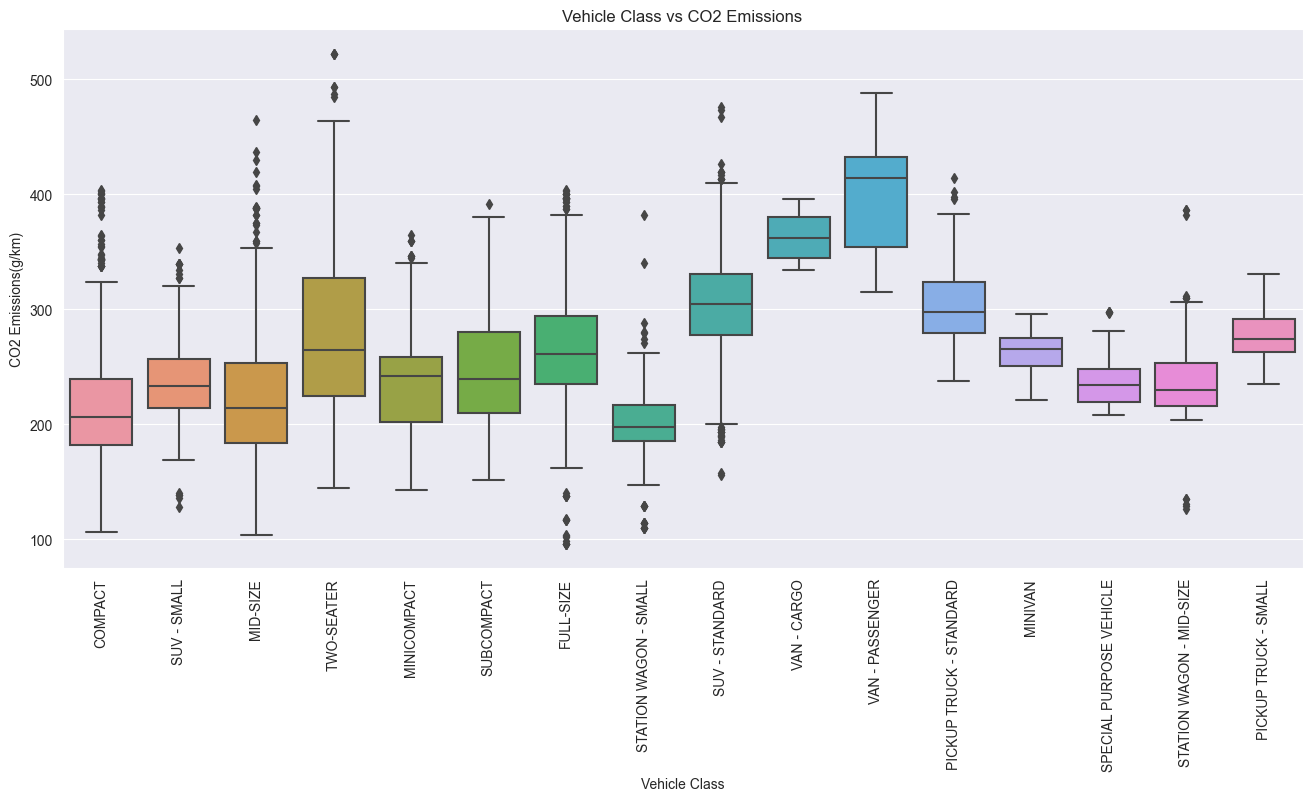

In [43]:
plt.figure(figsize=(16, 7))
sns.boxplot(data=df, x="Vehicle Class", y="CO2 Emissions(g/km)")
plt.xticks(rotation=90)
plt.title("Vehicle Class vs CO2 Emissions")
plt.show()

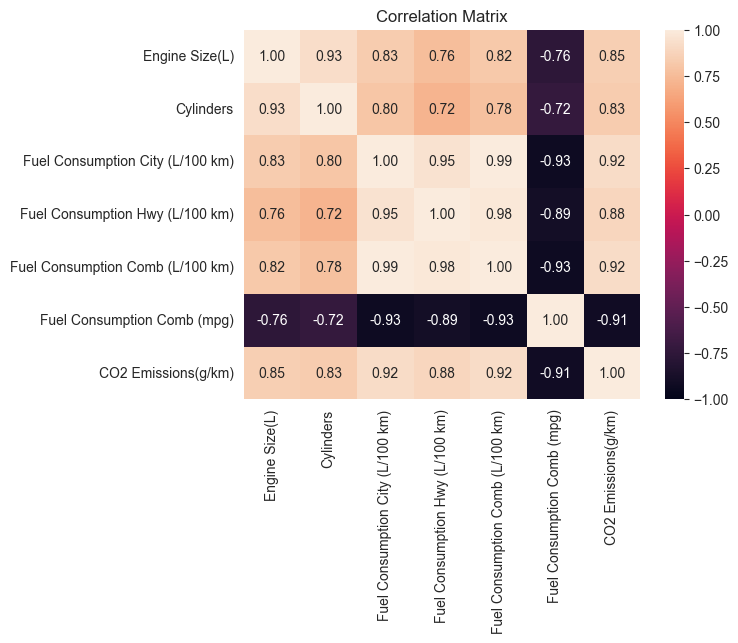

In [44]:
sns.heatmap(df.corr(), annot=True, fmt=".2f", vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")
plt.show()

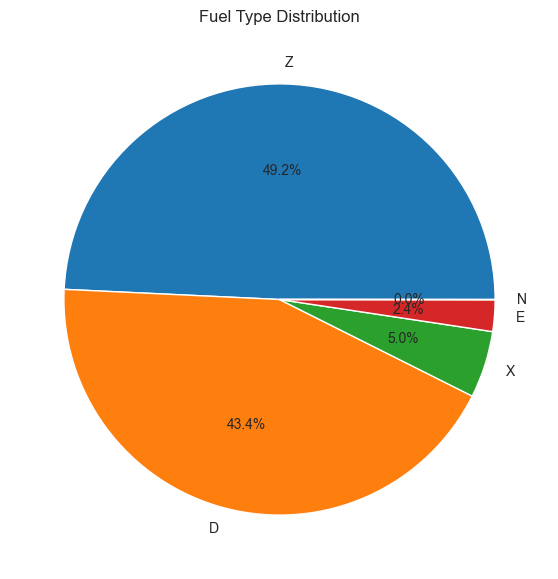

In [45]:
plt.figure(figsize=(7, 7))
plt.pie(df["Fuel Type"].value_counts(), labels=df["Fuel Type"].unique(), autopct="%1.1f%%")
plt.title("Fuel Type Distribution")
plt.show()

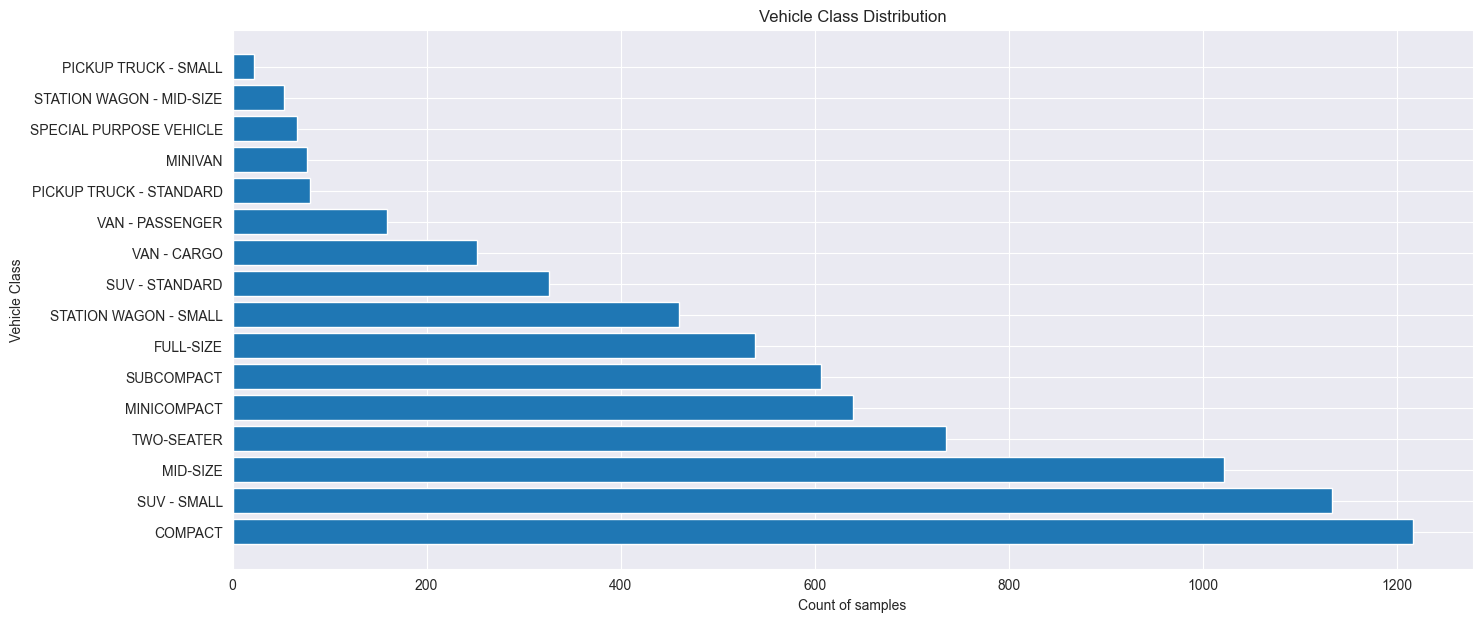

In [46]:
plt.figure(figsize=(16, 7))
plt.barh(df["Vehicle Class"].unique(), df["Vehicle Class"].value_counts())
plt.title("Vehicle Class Distribution")
plt.xlabel("Count of samples")
plt.ylabel("Vehicle Class")
plt.show()

### **Insights**

The data analysis shows that the dataset is fairly balanced, and contains a large number of samples. The following insights can be drawn from the analysis:

- Most features show strong positive correlation with each other, apart from `Fuel Consumption Comb (mpg)`, which shows strong negative correlation with the all other features.
- The `Vehicle Class` of `VAN - PASSENGER` consistently has the highest average `CO2 Emissions(g/km)`, while the `Vehicle Class` of `COMPACT` consistently has the lowest average `CO2 Emissions(g/km)`, with a few outliers.
- The `Vehicle Class` of `STATION WAGON - SMALL` has the highest number of samples, while the `Vehicle Class` of `PICKUP TRUCK - SMALL` has the lowest number of samples in the dataset.
- The distribution of the target variable and `Fuel Consumption Comb (mpg)` are gaussian, with a slight skew to the left.
- The `Fuel Type` distribution suggests that the `Z` and `D` types dominate the dataset, while the `X` and `E` types are the least common.
- The pairplot suggests that the number of `Cylinders` in the engine shows high variation in correlating with the other features.
- The pairplot also displays that the `Engine Size` and `Fuel Consumption (L/100)` features are the most correlated with the `CO2 Emissions (g/km)` feature. The negative correlation between `Fuel Consumption Comb (mpg)` and other features is also evident.
- Overall, all features are strongly correlated with `CO2 Emissions (g/km)`, which is a good indicator that the model will perform well.

In [47]:
numerical = df.select_dtypes(include=["int", "float"]).columns.tolist()
categorical = df.select_dtypes(include=["object"]).columns.tolist()

### **Applying $t$-SNE for visualization**

To visualize the separation of the high-dimensional data, we use $t$-SNE Algorithm to reduce the dimensionality of the data to $2$ dimensions. The results are shown below. 

The $t$-SNE Algorithm does a good job of separating the data into different clusters. The clusters are well separated and not too dense. This is a good indicator that based on the features, the model will be able to perform well.

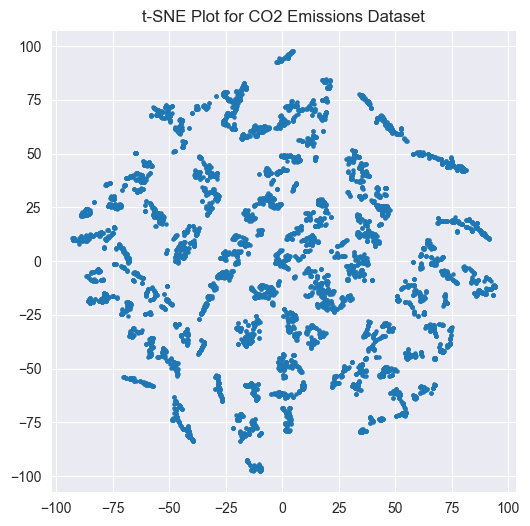

In [60]:
tsne = TSNE(n_components=2, learning_rate=100, n_iter=1250)
X_tsne = tsne.fit_transform(StandardScaler().fit_transform(df[numerical]))

plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=5.0)
plt.title("t-SNE Plot for CO2 Emissions Dataset")
plt.show()

### **Training the Model**

We train a Linear Regression model on the dataset with `CO2 Emissions (g/km)` as the target variable. The dataset is preprocessed for handling categorical and numerical features.

The categorical features are encoded using Label Encoding. The dataset is split into training and testing. The final results are shown below.

In [49]:
encoder = LabelEncoder()
for column in categorical:
    df[column] = encoder.fit_transform(df[column])

X = StandardScaler().fit_transform(df.drop("CO2 Emissions(g/km)", axis=1).values)
Y = df["CO2 Emissions(g/km)"].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [50]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
scores = evaluate_model(model, x_train, y_train, x_test, y_test)

scores = pd.DataFrame(scores, columns=["MSE", "RMSE", "R2", "Adj R2", "MAE"], index=["Train", "Test"])
scores

,MSE,RMSE,R2,Adj R2,MAE
Train,281.265385,16.770969,0.917737,0.917583,10.895079
Test,314.757425,17.741404,0.908496,0.907809,11.480851


### **Dimensionality Reduction using PCA**

We try to reduce the dimensionality of the dataset using PCA to various smaller number of dimensions. We then train a Linear Regression model on the reduced dataset. The results are shown below.

In [51]:
n_components = [4, 6, 8, 10]
evaluation = np.zeros((len(n_components), 2, 5))

for i, n in enumerate(n_components):
    pca = PCA(n_components=n)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    model = LinearRegression(fit_intercept=True)
    model.fit(x_train_pca, y_train)
    evaluation[i] = evaluate_model(model, x_train_pca, y_train, x_test_pca, y_test)

scores = pd.DataFrame(columns=["type", "n_components", "MSE", "RMSE", "R2", "Adj R2", "MAE"])
for i, n in enumerate(n_components):
    scores.loc[2*i] = ["TRAIN", n, *evaluation[i, 0]]
    scores.loc[2*i+1] = ["TEST", n, *evaluation[i, 1]]
scores

,type,n_components,MSE,RMSE,R2,Adj R2,MAE
0,TRAIN,4,299.821725,17.315361,0.912309,0.912250,11.647127
1,TEST,4,335.452564,18.315364,0.902479,0.902214,12.191652
2,TRAIN,6,294.929584,17.173514,0.913740,0.913653,11.630140
3,TEST,6,330.499198,18.179637,0.903919,0.903527,12.129999
4,TRAIN,8,282.798371,16.816610,0.917288,0.917176,10.930857
5,TEST,8,314.778401,17.741995,0.908490,0.907991,11.455497
6,TRAIN,10,281.292460,16.771776,0.917729,0.917589,10.897190
7,TEST,10,314.853074,17.744100,0.908468,0.907844,11.481140


### **Using Stochastic Gradient Descent with Label Encoding**

We then use the `SGDRegressor` to train a Linear Regression model. The categorical features of the dataset are encoded using Label Encoding. The results are shown below.

In [52]:
model = SGDRegressor()
model.fit(x_train, y_train)
scores = evaluate_model(model, x_train, y_train, x_test, y_test)

scores = pd.DataFrame(scores, columns=["MSE", "RMSE", "R2", "Adj R2", "MAE"], index=["TRAIN", "TEST"])
scores

,MSE,RMSE,R2,Adj R2,MAE
TRAIN,281.552014,16.779512,0.917653,0.917499,10.849454
TEST,316.906538,17.801869,0.907871,0.907179,11.442893


### **Using One-Hot Encoding for Categorical Features**

Instead of using Label Encoding for categorical features, we use One-Hot Encoding to encode the categorical features. We then train a Linear Regression model on the encoded dataset. The results are shown below.

In [53]:
encoder = OneHotEncoder(drop="first", sparse=False)
encoded_categorical = encoder.fit_transform(df[categorical])

encoded_feats = encoder.get_feature_names_out(input_features=categorical)
encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_feats)
 
X = StandardScaler().fit_transform(np.concatenate((df[numerical], encoded_df), axis=1))
Y = df["CO2 Emissions(g/km)"].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### **$t$-SNE Plot to check Separation**

The separation of the dataset is checked again after applying One-Hot Encoding. The results are shown below. The plot still contains well-defined clusters.

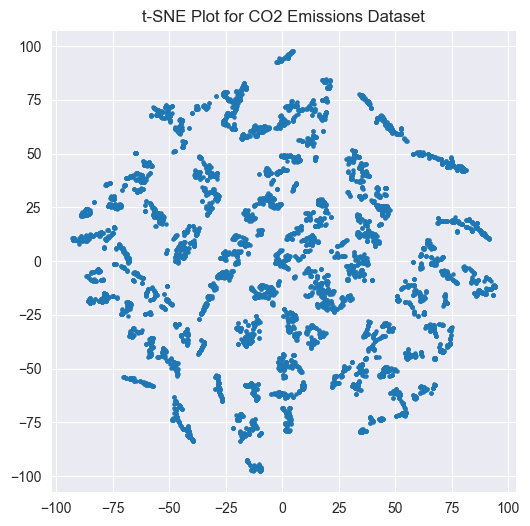

In [62]:
tsne = TSNE(n_components=2, learning_rate=100, n_iter=1250)
X_tsne = tsne.fit_transform(StandardScaler().fit_transform(df[numerical]))

plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=5.0)
plt.title("t-SNE Plot for CO2 Emissions Dataset")
plt.show()

### **Training the Model**

Now, we train the simple Linear Regression mmodel on the same dataset encoded using One-Hot Encoding.

In [63]:
model = LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
scores = evaluate_model(model, x_train, y_train, x_test, y_test)

scores = pd.DataFrame(scores, columns=["MSE", "RMSE", "R2", "Adj R2", "MAE"], index=["TRAIN", "TEST"])
scores

,MSE,RMSE,R2,Adj R2,MAE
TRAIN,5.988296e-26,2.447100e-13,1.000000,1.000000,1.830670e-13
TEST,1.747672e+02,1.321995e+01,0.946793,1.117389,3.016970e+00


### **Dimensionality Reduction using PCA**

The One-Hot Encoded data is fed into the PCA Algorithm to reduce the dimensionality of the dataset. Different models are trained on the data with reduced dimensions. The results are shown below.

In [64]:
n_components = [4, 6, 8, 10]
evaluation = np.zeros((len(n_components), 2, 5))

for i, n in enumerate(n_components):
    pca = PCA(n_components=n)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    model = LinearRegression(fit_intercept=True)
    model.fit(x_train_pca, y_train)
    evaluation[i] = evaluate_model(model, x_train_pca, y_train, x_test_pca, y_test)

scores = pd.DataFrame(columns=["Type", "n_components", "MSE", "RMSE", "R2", "Adj R2", "MAE"])
for i, n in enumerate(n_components):
    scores.loc[2*i] = ["TRAIN", n, *evaluation[i, 0]]
    scores.loc[2*i+1] = ["TEST", n, *evaluation[i, 1]]
scores

,Type,n_components,MSE,RMSE,R2,Adj R2,MAE
0,TRAIN,4,388.976033,19.722475,0.887511,0.887435,13.578267
1,TEST,4,364.943599,19.103497,0.888895,0.888593,13.406922
2,TRAIN,6,377.025130,19.417135,0.890967,0.890856,13.287736
3,TEST,6,360.886895,18.997023,0.890130,0.889681,13.319785
4,TRAIN,8,367.348632,19.166341,0.893765,0.893621,13.119784
5,TEST,8,350.721288,18.727554,0.893225,0.892643,13.127520
6,TRAIN,10,344.416202,18.558454,0.900397,0.900228,12.918078
7,TEST,10,335.356171,18.312732,0.897903,0.897206,12.956610


### **Using Stochastic Gradient Descent with One-Hot Encoding**

We now use the Stochastic Gradient Descent Regressor. The categorical features are encoded using One-Hot Encoding. The results are shown below.

In [65]:
model = SGDRegressor()
model.fit(x_train, y_train)
scores = evaluate_model(model, x_train, y_train, x_test, y_test)

scores = pd.DataFrame(scores, columns=["MSE", "RMSE", "R2", "Adj R2", "MAE"], index=["TRAIN", "TEST"])
scores

,MSE,RMSE,R2,Adj R2,MAE
TRAIN,8.061941e+20,2.839356e+10,-2.331457e+17,-3.660796e+17,1.949024e+09
TEST,2.510900e+18,1.584582e+09,-7.644305e+14,1.686546e+15,7.947141e+08


### **Regularization**

Finally, we add regularization to the Linear Regression model. We check two types of regularization, namely $L_{1}$ (Lasso) and $L_{2}$ (Ridge) regularization. The results are shown below.

In [66]:
L1 = Lasso(alpha=0.01)
L1.fit(x_train, y_train)
score_l1 = evaluate_model(L1, x_train, y_train, x_test, y_test)

L2 = Ridge(alpha=0.01)
L2.fit(x_train, y_train)
score_l2 = evaluate_model(L2, x_train, y_train, x_test, y_test)

scores = pd.DataFrame(columns=["Type", "Regulariation", "MSE", "RMSE", "R2", "Adj R2", "MAE"])
scores.loc[0] = ["TRAIN", "L1", *score_l1[0]]
scores.loc[1] = ["TEST", "L1", *score_l1[1]]
scores.loc[2] = ["TRAIN", "L2", *score_l2[0]]
scores.loc[3] = ["TEST", "L2", *score_l2[1]]    
scores

,Type,Regulariation,MSE,RMSE,R2,Adj R2,MAE
0,TRAIN,L1,0.000156,0.012504,1.0,1.0,0.009402
1,TEST,L1,0.000145,0.012057,1.0,1.0,0.009210
2,TRAIN,L2,0.000004,0.001960,1.0,1.0,0.001246
3,TEST,L2,0.000012,0.003402,1.0,1.0,0.002083


### **Observations and Comparison**

The above experiments indicate that:

- `LinearRegression` performs significantly better than `SGDRegressor`
- For `LabelEncoding`:
    - `LinearRegression` has an average RMSE of about $17$
    - Decreasing dimensionality with `PCA` results in a slight decrease in performance
    - The `SGDRegressor` performs as well as the `LinearRegression`
- For `OneHotEncoding`:
    - `LinearRegression` performs much better than with `LabelEncoding`, with an average RMSE close to $0.1$
    - Decreasing dimensionality with `PCA` does not affect the performance as strongly
    - The `SGDRegressor` performs slightly worse than the `LinearRegression`, however, it is still better than with `LabelEncoding`
- $L_{2}$ regularization results in a better model than $L_{1}$ regularization, at least in terms of MSE